In [69]:
# Importing Libraries

import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import matplotlib.pyplot as plt

# ML Libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import collections
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.neighbors import LocalOutlierFactor
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Low Conversion", "High Conversion"]

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Loading the Data and EDA

In [70]:
import pandas as pd

missing_value = ["n.a.","NA","n/a", "na", "NaN", "NULL", "None"]

data = pd.read_excel("Dataset.xlsx", na_values = missing_value)
data.head()

,Customer_ID,Gender,Age,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Email_Unsubscribe_Date,Customer_Status,Status_Cancel_Date
0,1,F,25 to 34,2,2020-11-01 00:00:00,10 to 19,0,0,0,NaT,active,NaT
1,2,M,45 to 54,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,2020-08-04,cancel,2020-05-01
2,3,M,35 to 44,2,Before 2020,20 to 29,>25% to 50%,>25%,0,NaT,active,NaT
3,4,F,55+,2,2020-08-01 00:00:00,20 to 29,0,0,1,2020-09-02,active,NaT
4,5,M,25 to 34,2,2020-02-01 00:00:00,NaN,0,0,1,2019-08-31,active,NaT


In [71]:
data.isnull().max()

Customer_ID               False
Gender                     True
Age                       False
Boxes_Purchased_Cnt       False
Last_Purchase_Date        False
Unique_Emails_Sent         True
Open_Rate                 False
Click_to_Open_Rate        False
Email_Unsubscribe_Ind     False
Email_Unsubscribe_Date     True
Customer_Status           False
Status_Cancel_Date         True
dtype: bool

It can be seen that the dataset has missing values for features: Gender, Email_Unsubscribe_Date and Status_Cancel_Date. Before creating any models, we need to impute these missing values with an appropriate method.

In [72]:
len(data)

4000

It looks like there aren't many customers that have canceled the subscription. Let's take a look at the distribution of the Customer_Status : 

In [73]:
print('Active Subscriptions are', round(data['Customer_Status'].str.contains('active').sum()/len(data) * 100,2), '% of the dataset')
print('Canceled Subscriptions are', round(data['Customer_Status'].str.contains('cancel').sum()/len(data) * 100,2), '% of the dataset')

Active Subscriptions are 90.52 % of the dataset
Canceled Subscriptions are 9.48 % of the dataset


Text(0.5, 1.0, 'Distribution of 2 classes \n (1: Active || 0: Canceled)')

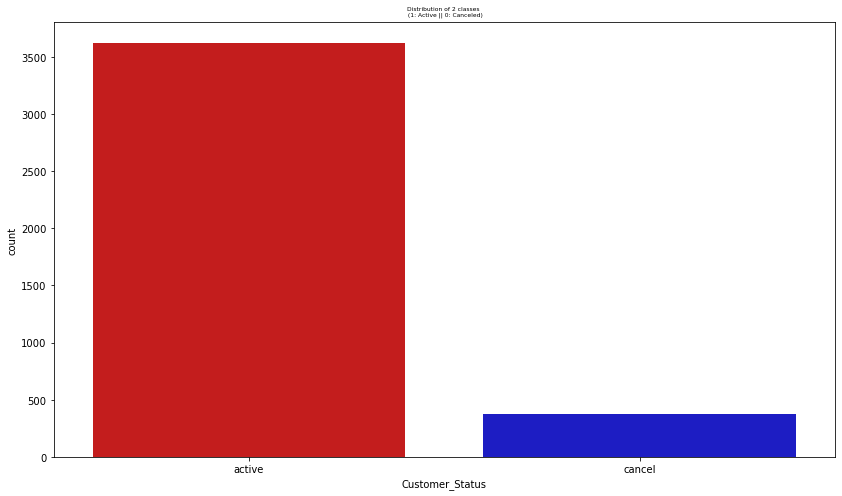

In [74]:
colors = ["#DF0101", "#0101DF"]
sns.countplot('Customer_Status', data=data, palette=colors)
plt.title('Distribution of 2 classes \n (1: Active || 0: Canceled)', fontsize=6)

 From the above exhibit, we can see that the data is skewed with respect to the customer status
. Therefore, if we want to predict cancelation for a new customer, we should first take care of the imbalanced structure of the data
 by resampling methods and create an even distribution for both classes ( active, cancel). One way of doing so is to undersample 
the active customers and have a 50/50 distribution of both classes and then train a model.

In [75]:
print(data.isnull().sum())

Customer_ID                  0
Gender                     255
Age                          0
Boxes_Purchased_Cnt          0
Last_Purchase_Date           0
Unique_Emails_Sent         196
Open_Rate                    0
Click_to_Open_Rate           0
Email_Unsubscribe_Ind        0
Email_Unsubscribe_Date    3476
Customer_Status              0
Status_Cancel_Date        3627
dtype: int64


# Imputing Gender

In [76]:
# Finding the mode of Gender
data['Gender'].mode()

0    F
dtype: object

In [77]:
data['Gender'].fillna('F', inplace=True)


In [78]:
print(data.isnull().sum())

Customer_ID                  0
Gender                       0
Age                          0
Boxes_Purchased_Cnt          0
Last_Purchase_Date           0
Unique_Emails_Sent         196
Open_Rate                    0
Click_to_Open_Rate           0
Email_Unsubscribe_Ind        0
Email_Unsubscribe_Date    3476
Customer_Status              0
Status_Cancel_Date        3627
dtype: int64


In [79]:
data['Email_Unsubscribe_Date'].isnull().sum()


3476

In [80]:
data['Status_Cancel_Date'].isnull().sum()

3627

It looks like that we have around 87% missing values in the column Email_Unsubscribe_Date and about 90% in Status_Cancel_Date.
 We can drop these columns and do the analysis based on the rest of the data.

In [81]:

data.drop(['Email_Unsubscribe_Date'], axis = 1, inplace = True)
data.drop(['Status_Cancel_Date'], axis = 1, inplace = True)

data.head()

,Customer_ID,Gender,Age,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Customer_Status
0,1,F,25 to 34,2,2020-11-01 00:00:00,10 to 19,0,0,0,active
1,2,M,45 to 54,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,cancel
2,3,M,35 to 44,2,Before 2020,20 to 29,>25% to 50%,>25%,0,active
3,4,F,55+,2,2020-08-01 00:00:00,20 to 29,0,0,1,active
4,5,M,25 to 34,2,2020-02-01 00:00:00,NaN,0,0,1,active


# Modifying Age from Range to Mean

In [82]:
data['Age'].unique()

array(['25 to 34', '45 to 54', '35 to 44', '55+', '18 to 24'],
      dtype=object)

In [83]:
def age_mean(x):
    if x == '25 to 34':
        return int((25+34)/2)
    elif x == '45 to 54':
        return int((45+54)/2)
    elif x == '35 to 44':
        return int((35+44)/2)
    elif x == '18 to 24':
        return int((18+24)/2)
    elif x == '55+':
        return 55


In [84]:
data['mean_age'] = data['Age'].apply(age_mean)
mean_age = data['mean_age']

In [85]:
data.drop(['Age'], axis = 1 , inplace = True)

In [86]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Customer_Status,mean_age
0,1,F,2,2020-11-01 00:00:00,10 to 19,0,0,0,active,29
1,2,M,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,cancel,49
2,3,M,2,Before 2020,20 to 29,>25% to 50%,>25%,0,active,39
3,4,F,2,2020-08-01 00:00:00,20 to 29,0,0,1,active,55
4,5,M,2,2020-02-01 00:00:00,NaN,0,0,1,active,29


# Modifying Unique Emails Sent from Range to Mean

In [87]:
data['Unique_Emails_Sent'] = data['Unique_Emails_Sent'].fillna(0)
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Customer_Status,mean_age
0,1,F,2,2020-11-01 00:00:00,10 to 19,0,0,0,active,29
1,2,M,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,cancel,49
2,3,M,2,Before 2020,20 to 29,>25% to 50%,>25%,0,active,39
3,4,F,2,2020-08-01 00:00:00,20 to 29,0,0,1,active,55
4,5,M,2,2020-02-01 00:00:00,0,0,0,1,active,29


In [88]:
print(data.isnull().sum())

Customer_ID              0
Gender                   0
Boxes_Purchased_Cnt      0
Last_Purchase_Date       0
Unique_Emails_Sent       0
Open_Rate                0
Click_to_Open_Rate       0
Email_Unsubscribe_Ind    0
Customer_Status          0
mean_age                 0
dtype: int64


In [89]:
data['Unique_Emails_Sent'].unique()

array(['10 to 19', '20 to 29', 0, '30 to 49', 'Less than 10', '50+'],
      dtype=object)

In [90]:
def email_mean(y):
    if y == '10 to 19':
        return int((10+19)/2)
    elif y == '20 to 29':
        return int((20+29)/2)
    elif y == '30 to 49':
        return int((30+49)/2)
    elif y == 'Less than 10':
        return 10
    elif y == '50+':
        return 50
    elif y == 0 :
        return 0

In [91]:
data['mean_num_email_sent'] = data['Unique_Emails_Sent'].apply(email_mean)
mean_num_email_sent = data['mean_num_email_sent']

In [92]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Unique_Emails_Sent,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent
0,1,F,2,2020-11-01 00:00:00,10 to 19,0,0,0,active,29,14
1,2,M,1,2020-05-01 00:00:00,10 to 19,>50% to 75%,>0% to 10%,1,cancel,49,14
2,3,M,2,Before 2020,20 to 29,>25% to 50%,>25%,0,active,39,24
3,4,F,2,2020-08-01 00:00:00,20 to 29,0,0,1,active,55,24
4,5,M,2,2020-02-01 00:00:00,0,0,0,1,active,29,0


In [93]:
data.drop(['Unique_Emails_Sent'], axis = 1 , inplace = True)

In [94]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent
0,1,F,2,2020-11-01 00:00:00,0,0,0,active,29,14
1,2,M,1,2020-05-01 00:00:00,>50% to 75%,>0% to 10%,1,cancel,49,14
2,3,M,2,Before 2020,>25% to 50%,>25%,0,active,39,24
3,4,F,2,2020-08-01 00:00:00,0,0,1,active,55,24
4,5,M,2,2020-02-01 00:00:00,0,0,1,active,29,0


In [95]:
data['Open_Rate'].unique()

array([0, '>50% to 75%', '>25% to 50%', '>0% to 25%', '>75%'],
      dtype=object)

# Calculationg Average Open Rate for Each Customer

In [96]:
def open_rate_average(z):
    if z == '>50% to 75%':
        return (50+75)/2
    elif z == '>25% to 50%':
        return (25+50)/2
    elif z == '>0% to 25%':
        return (25)/2
    elif z == '>75%':
        return (75+100)/2
    elif z == 0:
        return 0
    

In [97]:
data['open_rate_avg'] = data['Open_Rate'].apply(open_rate_average)
open_rate_avg = data['open_rate_avg']
data.head()


,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Open_Rate,Click_to_Open_Rate,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg
0,1,F,2,2020-11-01 00:00:00,0,0,0,active,29,14,0.0
1,2,M,1,2020-05-01 00:00:00,>50% to 75%,>0% to 10%,1,cancel,49,14,62.5
2,3,M,2,Before 2020,>25% to 50%,>25%,0,active,39,24,37.5
3,4,F,2,2020-08-01 00:00:00,0,0,1,active,55,24,0.0
4,5,M,2,2020-02-01 00:00:00,0,0,1,active,29,0,0.0


In [98]:
data.drop(['Open_Rate'], axis = 1, inplace = True)

In [99]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Click_to_Open_Rate,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg
0,1,F,2,2020-11-01 00:00:00,0,0,active,29,14,0.0
1,2,M,1,2020-05-01 00:00:00,>0% to 10%,1,cancel,49,14,62.5
2,3,M,2,Before 2020,>25%,0,active,39,24,37.5
3,4,F,2,2020-08-01 00:00:00,0,1,active,55,24,0.0
4,5,M,2,2020-02-01 00:00:00,0,1,active,29,0,0.0


# Calculationg Average Click to Open Rate for Each Customer

In [100]:
data['Click_to_Open_Rate'].unique()

array([0, '>0% to 10%', '>25%', '>15% to 25%', '>10% to 15%'],
      dtype=object)

In [101]:
def click_to_open_rate_average(h):
    if h == '>0% to 10%':
        return (10)/2
    elif h == '>25%':
        return (25+30)/2
    elif h == '>15% to 25%':
        return (15+25)/2
    elif h == '>10% to 15%':
        return (10+15)/2
    elif h == 0:
        return 0

In [102]:
data['click_to_open_rate_avg'] = data['Click_to_Open_Rate'].apply(click_to_open_rate_average)
click_to_open_rate_avg = data['click_to_open_rate_avg']
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Click_to_Open_Rate,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg
0,1,F,2,2020-11-01 00:00:00,0,0,active,29,14,0.0,0.0
1,2,M,1,2020-05-01 00:00:00,>0% to 10%,1,cancel,49,14,62.5,5.0
2,3,M,2,Before 2020,>25%,0,active,39,24,37.5,27.5
3,4,F,2,2020-08-01 00:00:00,0,1,active,55,24,0.0,0.0
4,5,M,2,2020-02-01 00:00:00,0,1,active,29,0,0.0,0.0


In [103]:
data.drop(['Click_to_Open_Rate'], axis = 1, inplace = True)
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg
0,1,F,2,2020-11-01 00:00:00,0,active,29,14,0.0,0.0
1,2,M,1,2020-05-01 00:00:00,1,cancel,49,14,62.5,5.0
2,3,M,2,Before 2020,0,active,39,24,37.5,27.5
3,4,F,2,2020-08-01 00:00:00,1,active,55,24,0.0,0.0
4,5,M,2,2020-02-01 00:00:00,1,active,29,0,0.0,0.0


# Purchases in 2020

Now we create a new boolean feature based on the purchases in 2020. If the customer made no purchases in 2020, it will be shown
with 0 and otherwise with 1.

In [104]:
data['Last_Purchase_Date'].unique()

array([datetime.datetime(2020, 11, 1, 0, 0),
       datetime.datetime(2020, 5, 1, 0, 0), 'Before 2020',
       datetime.datetime(2020, 8, 1, 0, 0),
       datetime.datetime(2020, 2, 1, 0, 0),
       datetime.datetime(2020, 12, 1, 0, 0),
       datetime.datetime(2020, 3, 1, 0, 0),
       datetime.datetime(2020, 7, 1, 0, 0),
       datetime.datetime(2020, 9, 1, 0, 0),
       datetime.datetime(2020, 1, 1, 0, 0),
       datetime.datetime(2020, 4, 1, 0, 0),
       datetime.datetime(2020, 10, 1, 0, 0),
       datetime.datetime(2020, 6, 1, 0, 0)], dtype=object)

In [105]:
data['Last_Purchase_Date'].dtype
print(data.dtypes)

Customer_ID                 int64
Gender                     object
Boxes_Purchased_Cnt         int64
Last_Purchase_Date         object
Email_Unsubscribe_Ind       int64
Customer_Status            object
mean_age                    int64
mean_num_email_sent         int64
open_rate_avg             float64
click_to_open_rate_avg    float64
dtype: object


In [106]:
data.Last_Purchase_Date[data.Last_Purchase_Date == 'Before 2020'] = '2019-12-01 00:00:00'



In [107]:
data['Last_Purchase_Date'] = pd.to_datetime(data['Last_Purchase_Date'])
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg
0,1,F,2,2020-11-01,0,active,29,14,0.0,0.0
1,2,M,1,2020-05-01,1,cancel,49,14,62.5,5.0
2,3,M,2,2019-12-01,0,active,39,24,37.5,27.5
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0


In [108]:
print(data.dtypes)


Customer_ID                        int64
Gender                            object
Boxes_Purchased_Cnt                int64
Last_Purchase_Date        datetime64[ns]
Email_Unsubscribe_Ind              int64
Customer_Status                   object
mean_age                           int64
mean_num_email_sent                int64
open_rate_avg                    float64
click_to_open_rate_avg           float64
dtype: object


In [109]:
import datetime as dt
def purchase(s): 
    if s.year == 2020:
        return 1
    else:
        return 0
    

In [110]:
data['Purchase_in_2020'] = data['Last_Purchase_Date'].apply(purchase)
purchase_in_2020 = data['Purchase_in_2020']
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020
0,1,F,2,2020-11-01,0,active,29,14,0.0,0.0,1
1,2,M,1,2020-05-01,1,cancel,49,14,62.5,5.0,1
2,3,M,2,2019-12-01,0,active,39,24,37.5,27.5,0
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0,1


In [111]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020
0,1,F,2,2020-11-01,0,active,29,14,0.0,0.0,1
1,2,M,1,2020-05-01,1,cancel,49,14,62.5,5.0,1
2,3,M,2,2019-12-01,0,active,39,24,37.5,27.5,0
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0,1


In [112]:
#data.to_csv(r'C:\Users\Simas\Desktop\data.csv')

In [113]:
base = data['Last_Purchase_Date'].max()
data['days_since_last_purchase'] = base - data['Last_Purchase_Date']
data['days_since_last_purchase']
data['days_since_last_purchase'] = (data['days_since_last_purchase']).dt.days
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase
0,1,F,2,2020-11-01,0,active,29,14,0.0,0.0,1,30
1,2,M,1,2020-05-01,1,cancel,49,14,62.5,5.0,1,214
2,3,M,2,2019-12-01,0,active,39,24,37.5,27.5,0,366
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1,122
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0,1,304


In [114]:
data['conversion'] = round(data['open_rate_avg']*data['click_to_open_rate_avg']/100, 2)

In [115]:
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase,conversion
0,1,F,2,2020-11-01,0,active,29,14,0.0,0.0,1,30,0.00
1,2,M,1,2020-05-01,1,cancel,49,14,62.5,5.0,1,214,3.12
2,3,M,2,2019-12-01,0,active,39,24,37.5,27.5,0,366,10.31
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1,122,0.00
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0,1,304,0.00


In [116]:
data['conversion'].unique()

array([ 0.  ,  3.12, 10.31,  1.88,  7.5 ,  7.81,  0.62,  2.5 ,  4.69,
       10.94,  1.56,  3.44, 17.19,  4.38, 12.5 , 24.06, 17.5 ])

In [117]:
# # we drop the customers that never open any emails
# data = data[data.conversion >0]
# data.head()

<AxesSubplot:>

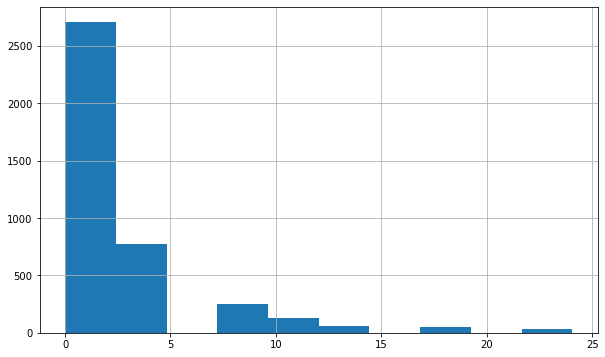

In [118]:
data['conversion'].hist(figsize = (10,6))

**We can clearly see the class imbalance for conversion based on the chart above. We need to take care of this before training a model. I use undersampling method in which, I try to undersample the overrepresented calss to create a 50/50 distribution of the output class.**

In [119]:
# We assume that a conversion rate of 5% and above is high and we show it with 1.

def mapper(x):
    if x>= 5:
        return 1
    elif x< 5:
        return 0
data['conversion_binary'] = data['conversion'].apply(mapper)
conversion_binary = data['conversion_binary']


In [120]:
data[data['conversion_binary'] == 1]

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase,conversion,conversion_binary
2,3,M,2,2019-12-01,0,active,39,24,37.5,27.5,0,366,10.31,1
8,9,M,2,2020-12-01,0,active,39,39,37.5,20.0,1,0,7.50,1
21,22,F,5,2020-05-01,0,active,39,14,62.5,12.5,1,214,7.81,1
28,29,M,1,2020-12-01,0,active,29,14,37.5,20.0,1,0,7.50,1
30,31,M,1,2019-12-01,0,cancel,29,39,87.5,12.5,0,366,10.94,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,3953,M,1,2019-12-01,0,cancel,49,39,62.5,12.5,0,366,7.81,1
3956,3957,F,1,2020-10-01,0,active,29,24,37.5,27.5,1,61,10.31,1
3978,3979,F,2,2019-12-01,1,active,49,39,37.5,20.0,0,366,7.50,1
3986,3987,F,3,2020-02-01,0,active,55,39,37.5,27.5,1,304,10.31,1


In [121]:
def gen_model(n):
    if n == 'M':
        return 1
    else:
        return 0
data['Male'] = data['Gender'].apply(gen_model)
Male = data['Male']

data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase,conversion,conversion_binary,Male
0,1,F,2,2020-11-01,0,active,29,14,0.0,0.0,1,30,0.00,0,0
1,2,M,1,2020-05-01,1,cancel,49,14,62.5,5.0,1,214,3.12,0,1
2,3,M,2,2019-12-01,0,active,39,24,37.5,27.5,0,366,10.31,1,1
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1,122,0.00,0,0
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0,1,304,0.00,0,1


# Customer Churn Prediction


# Solving Class Imbalance by Undersampling

In [122]:
data[data['Email_Unsubscribe_Ind'] == 1]

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase,conversion,conversion_binary,Male
1,2,M,1,2020-05-01,1,cancel,49,14,62.5,5.0,1,214,3.12,0,1
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1,122,0.00,0,0
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0,1,304,0.00,0,1
9,10,F,5,2019-12-01,1,active,39,14,62.5,0.0,0,366,0.00,0,0
13,14,F,1,2020-01-01,1,active,39,0,0.0,0.0,1,335,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,3947,F,2,2019-12-01,1,active,55,0,0.0,0.0,0,366,0.00,0,0
3957,3958,F,1,2019-12-01,1,active,29,0,0.0,0.0,0,366,0.00,0,0
3966,3967,M,2,2019-12-01,1,active,55,0,0.0,0.0,0,366,0.00,0,1
3971,3972,M,1,2020-10-01,1,active,55,0,0.0,0.0,1,61,0.00,0,1


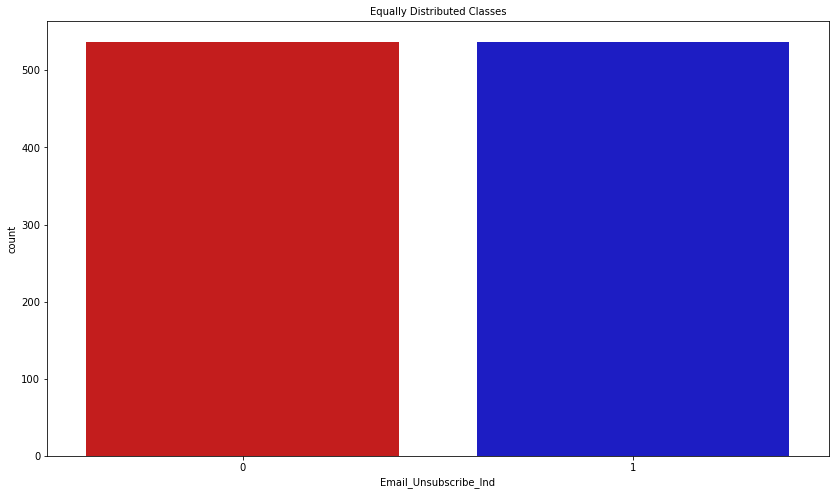

In [123]:
# Handling imbalanced structure of the data with undersampling the overpresented class 
# Just for building the model not for testing!(avoiding overfitting)
# I shuffle the data before creating the sub sample
data1 = data.sample(frac=1, random_state=42)

# amount of high conversion classes 86 rows.
unsubscribe_data = data1.loc[data1['Email_Unsubscribe_Ind'] == 1]
rest_data = data1.loc[data1['Email_Unsubscribe_Ind'] == 0][:537]

normal_distributed_data = pd.concat([unsubscribe_data, rest_data])

# Shuffle dataframe rows
new_data = normal_distributed_data.sample(frac=1, random_state=42)


sns.countplot('Email_Unsubscribe_Ind', data=new_data, palette=colors)
plt.title('Equally Distributed Classes', fontsize=10)
plt.show()

# Churn EDA

Text(0.5, 1.0, 'Customer Churn Distribution')

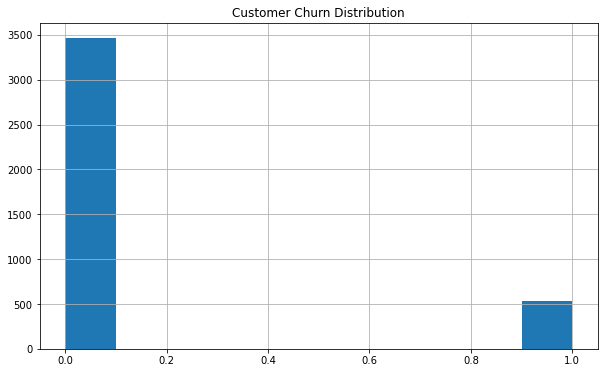

In [124]:
data['Email_Unsubscribe_Ind'].hist(figsize = (10,6))
plt.title('Customer Churn Distribution')

In [125]:
# Another churn prediction
# Looking at the number of days since last purchase:
base = new_data['Last_Purchase_Date'].max()
new_data['days_since_last_purchase'] = base - new_data['Last_Purchase_Date']
new_data['days_since_last_purchase']
new_data['days_since_last_purchase'] = (new_data['days_since_last_purchase']).dt.days
new_data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase,conversion,conversion_binary,Male
70,71,F,2,2019-12-01,0,active,49,24,12.5,12.5,0,366,1.56,0,0
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1,122,0.00,0,0
2673,2674,M,1,2019-12-01,1,active,55,0,0.0,0.0,0,366,0.00,0,1
1969,1970,F,3,2019-12-01,1,active,55,0,0.0,0.0,0,366,0.00,0,0
793,794,M,5,2020-11-01,1,active,55,0,0.0,0.0,1,30,0.00,0,1


In [126]:
print(data.dtypes)

Customer_ID                          int64
Gender                              object
Boxes_Purchased_Cnt                  int64
Last_Purchase_Date          datetime64[ns]
Email_Unsubscribe_Ind                int64
Customer_Status                     object
mean_age                             int64
mean_num_email_sent                  int64
open_rate_avg                      float64
click_to_open_rate_avg             float64
Purchase_in_2020                     int64
days_since_last_purchase             int64
conversion                         float64
conversion_binary                    int64
Male                                 int64
dtype: object


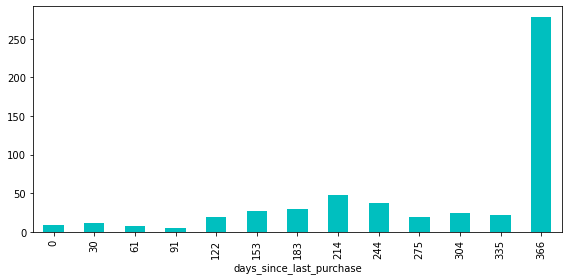

In [127]:
x = new_data.groupby('days_since_last_purchase')['Email_Unsubscribe_Ind'].sum().plot.bar(color='c',figsize=(8,4))
# plt.title('Churn based on days since last purchase')
plt.tight_layout()



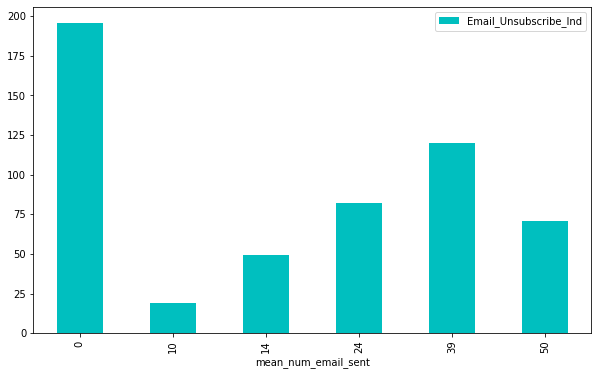

In [128]:
data.groupby('mean_num_email_sent')['Email_Unsubscribe_Ind'].sum().plot.bar(color = 'c', figsize = (10,6))
plt.legend()
plt.show()

In [129]:
data['churn'] = data['Email_Unsubscribe_Ind'] == 1
data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase,conversion,conversion_binary,Male,churn
0,1,F,2,2020-11-01,0,active,29,14,0.0,0.0,1,30,0.00,0,0,False
1,2,M,1,2020-05-01,1,cancel,49,14,62.5,5.0,1,214,3.12,0,1,True
2,3,M,2,2019-12-01,0,active,39,24,37.5,27.5,0,366,10.31,1,1,False
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1,122,0.00,0,0,True
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0,1,304,0.00,0,1,True


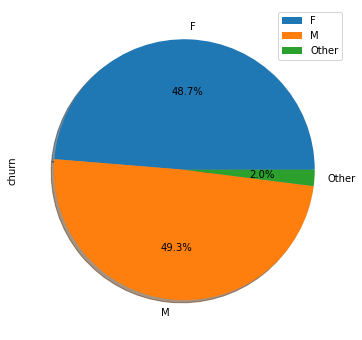

In [130]:

data['churn'] = data[data['Email_Unsubscribe_Ind'] == 1]

data.groupby('Gender')['churn'].sum().plot.pie(autopct='%1.1f%%',figsize = (10,6), shadow = True)
plt.legend()
plt.show()

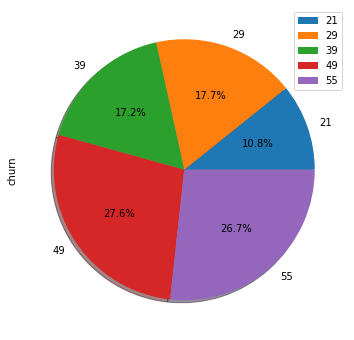

In [131]:
data.groupby('mean_age')['churn'].sum().plot.pie(autopct='%1.1f%%', figsize = (10,6), shadow = True)
plt.legend()
plt.show()

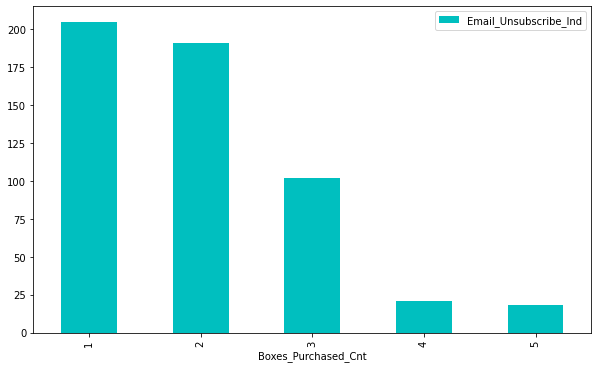

In [132]:
data.groupby('Boxes_Purchased_Cnt')['Email_Unsubscribe_Ind'].sum().plot.bar(color = 'c', figsize = (10,6))
plt.legend()
plt.show()

In [133]:
data[data['mean_num_email_sent']== 0]

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase,conversion,conversion_binary,Male,churn
4,5,M,2,2020-02-01,1,active,29,0,0.0,0.0,1,304,0.0,0,1,5.0
13,14,F,1,2020-01-01,1,active,39,0,0.0,0.0,1,335,0.0,0,0,14.0
40,41,F,1,2019-12-01,1,active,39,0,0.0,0.0,0,366,0.0,0,0,41.0
45,46,M,2,2019-12-01,1,active,29,0,0.0,0.0,0,366,0.0,0,1,46.0
64,65,F,2,2019-12-01,1,cancel,49,0,0.0,0.0,0,366,0.0,0,0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,3944,F,2,2019-12-01,1,active,39,0,0.0,0.0,0,366,0.0,0,0,3944.0
3946,3947,F,2,2019-12-01,1,active,55,0,0.0,0.0,0,366,0.0,0,0,3947.0
3957,3958,F,1,2019-12-01,1,active,29,0,0.0,0.0,0,366,0.0,0,0,3958.0
3966,3967,M,2,2019-12-01,1,active,55,0,0.0,0.0,0,366,0.0,0,1,3967.0


In [134]:
new_data.head()

,Customer_ID,Gender,Boxes_Purchased_Cnt,Last_Purchase_Date,Email_Unsubscribe_Ind,Customer_Status,mean_age,mean_num_email_sent,open_rate_avg,click_to_open_rate_avg,Purchase_in_2020,days_since_last_purchase,conversion,conversion_binary,Male
70,71,F,2,2019-12-01,0,active,49,24,12.5,12.5,0,366,1.56,0,0
3,4,F,2,2020-08-01,1,active,55,24,0.0,0.0,1,122,0.00,0,0
2673,2674,M,1,2019-12-01,1,active,55,0,0.0,0.0,0,366,0.00,0,1
1969,1970,F,3,2019-12-01,1,active,55,0,0.0,0.0,0,366,0.00,0,0
793,794,M,5,2020-11-01,1,active,55,0,0.0,0.0,1,30,0.00,0,1


# Decision Tree Model for Feature Importance

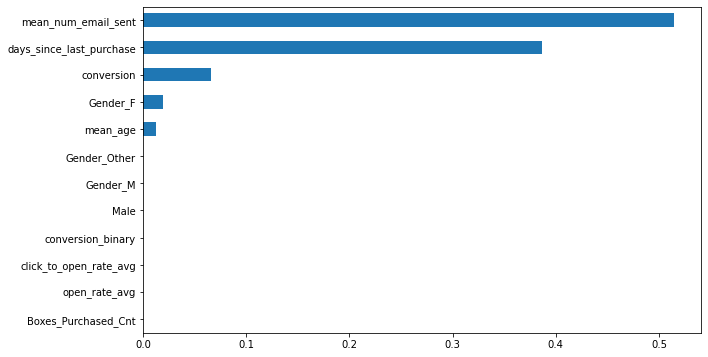

In [135]:
y = new_data['Email_Unsubscribe_Ind']
train = pd.get_dummies(new_data.drop(['Customer_ID', 'Email_Unsubscribe_Ind','Purchase_in_2020','Customer_Status','Last_Purchase_Date'], axis = 1))

tree = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', min_impurity_decrease = 0.001)
tree.fit(train, y)

feat_importances = pd.Series(tree.feature_importances_, 
                             index=train.columns)
feat_importances.sort_values().plot(kind='barh', figsize = (10,6))
plt.show()

# Customer Churn Prediction using Random Forest Algorithm

In [138]:
# Training
X = new_data.drop(['Email_Unsubscribe_Ind', 'Customer_ID', 'Purchase_in_2020','conversion','Customer_Status','Last_Purchase_Date', 'Gender', 'mean_age','open_rate_avg', 'click_to_open_rate_avg'], axis=1)
Z = new_data['Email_Unsubscribe_Ind']

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
Z_train = Z_train.values
Z_test = Z_test.values

from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

from sklearn.model_selection import cross_val_score


# RF = RandomForestClassifier()

#Random Forest Classifier
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid_forest = GridSearchCV(RandomForestClassifier(), param_grid)
grid_forest.fit(X_train, Z_train)

# RF best estimator
RF = grid_forest.best_estimator_

RF.fit(X_train, Z_train)
training_score = cross_val_score(RF, X_train, Z_train, cv=5)
print("Classifier: ", RF.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifier:  RandomForestClassifier Has a training score of 74.0 % accuracy score


Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       104
           1       0.76      0.79      0.78       111

    accuracy                           0.76       215
   macro avg       0.76      0.76      0.76       215
weighted avg       0.76      0.76      0.76       215

0.7627906976744186
Confusion matrix
[[76 28]
 [23 88]]
Confusion matrix
[[104   0]
 [  0 111]]


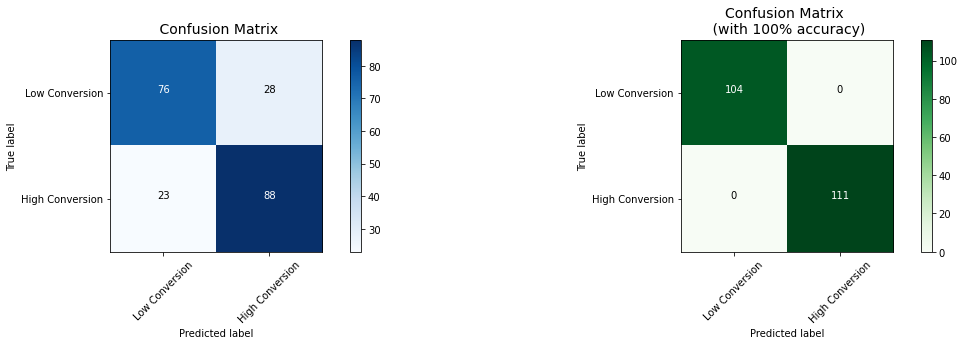

In [139]:

# Testing
from sklearn.metrics import accuracy_score

Z_pred_RF = RF.predict(X_test)

print('Random Forest Classifier:')
print(classification_report(Z_test, Z_pred_RF))
print(accuracy_score(Z_test, Z_pred_RF))


from sklearn.metrics import confusion_matrix

RF_cm = confusion_matrix(Z_test, Z_pred_RF)
actual_cm = confusion_matrix(Z_test,Z_test)
labels = ['Low Conversion', 'High Conversion']



import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




# plot_confusion_matrix(RF2_cf, labels, title=" Confusion Matrix", cmap=plt.cm.Reds)

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(RF_cm, labels, title=" Confusion Matrix", cmap=plt.cm.Blues)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

# Insights

We can see that the customers that haven't received any emails from us, have the highest churn and we need to investigate the reason for not sending them emails. Also, the more emails we send, the more likely the customers become to churn (Except for when we send 50+ emails that could be because of insufficient data in this category).

Days since last purchase also plays an important role in churning. For those who haven't bought anything in a year or more, churn is more likely to happen.

Looking at the number of boxes bought, we can see that those who bought 4 or 5 boxes are less likely to churn compared to those who bought 1 or 2 boxes.

And finally for age, the data shows that the customers above 45 are more likely to churn compared to the younger groups.




**Customer Churn Prediction**

Number of emails and wether they have purchased sth in 2020 or not are key factors.
Looking at the churn distribution, we can see that the customers that didn't get any emails were the ones who unsubscribed the most. REASON?? 

We try to predict the customer churn by a predictive model (Random Forest). We are able to predict churn by 75% accuracy with this model.

This number for accuracy is not great and it can be improved if we incorporate more features in the model. Features like Bounce, Email Length, Email Type (Personal or Generic) and day of week could add more accuracy to the model.





